In [0]:
import tensorflow as tf
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import argparse
import pdb
import easydict
from tqdm.notebook import tqdm
import os

In [0]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [0]:
def plot_img(epoch, status, img_output, img_GT):
    plt.figure(figsize=(12,3))
    
    noise = tf.keras.layers.GaussianNoise(0.1, input_shape=(32, 32, 3))
    
    noise_input = np.expand_dims(img_GT, 0)
    noise_input = noise(noise_input, training=True)
    noise_input = noise_input[0]

    plt.subplot(1,3,1)
    img_GT = np.array(img_GT)
    plt.imshow((img_GT*255).astype(np.uint8))
    plt.xlabel("{}, GT, Epoch: {}".format(status, epoch+1))
    
    plt.subplot(1,3,2)
    noise_input = np.array(noise_input)
    plt.imshow((noise_input*255).astype(np.uint8))
    plt.xlabel("{}, Noise Input, Epoch: {}".format(status, epoch+1))
    
    plt.subplot(1,3,3)
    img_output = np.array(img_output)
    plt.imshow((img_output*255).astype(np.uint8))
    plt.xlabel("{}, Output, Epoch: {}".format(status, epoch+1))
    
    plt.show()

In [0]:
class DeNoise(Model):
	def __init__(self):
		super(DeNoise, self).__init__()
		self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
		self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
		self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
		self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
		self.last_conv = tf.keras.layers.Conv2D(3, 3, padding='same', activation=None)
	
	def call(self, noise_input):
		x = self.conv1(noise_input)
		x = self.conv2(x)
		x = self.conv3(x)
		x = self.conv4(x)
		x = self.last_conv(x)
		x = x + noise_input
		return x

In [0]:
if __name__ == "__main__":
	parser = argparse.ArgumentParser()
	parser.add_argument('--epoch', type=int, default=1000, help='number of epochs')
	parser.add_argument('--batch', type=int, default=1000, help='batch size')
	parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
	parser.add_argument('--log_step', type=int, default=1, help='step for printing log')
	parser.add_argument('--img_show', type=str2bool, default=False, help='Show images while training')
	parser.add_argument('--inference', type=str2bool, default=True, help='Running inference code')
	parser.add_argument('--inf_img', type=str, default='', help='Path of inference input image')
	parser.add_argument('--output', type=str, default='', help='Path of inference result')

	#args = parser.parse_args()
	args = easydict.EasyDict({
		'epoch' : 100,
		'batch' : 32,
		'lr' : 0.001,
		'log_step' : 5,
		'img_show' : True,
		'inference' : True,
		'inf_img' : './noisy.png',
		'output' : './'
	})

	epochs = args.epoch
	BATCH_SIZE = args.batch
	lr = args.lr
	log_step = args.log_step

In [6]:
	# Load Data
	cifar10 = tf.keras.datasets.cifar10
	(x_train, _), (x_test, _) = cifar10.load_data()
	x_train, x_test = x_train / 255.0, x_test / 255.0
	y_train, y_test = x_train, x_test

	# Generate Dataset
	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)
	test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(10000).batch(BATCH_SIZE)

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
  # Generate Model
  model_2 = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1, input_shape=(32, 32, 3)),
    DeNoise()
  ])

  # Set Loss Function & Optimizer
  loss = tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  test_loss = tf.keras.metrics.Mean(name='test_loss')

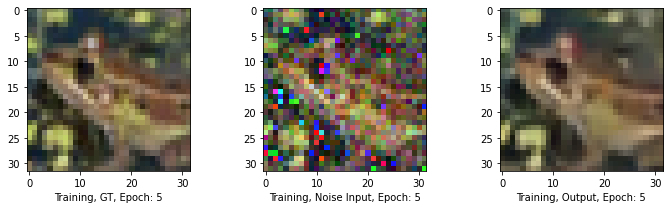

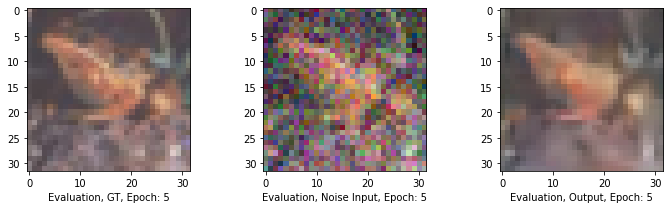

Epoch: 5 => train loss: 0.001576, test loss: 0.001460


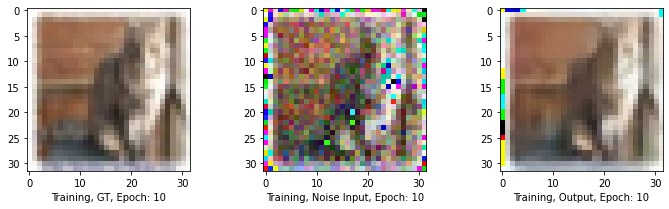

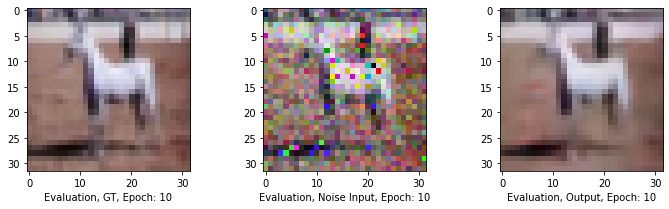

Epoch: 10 => train loss: 0.001511, test loss: 0.001446


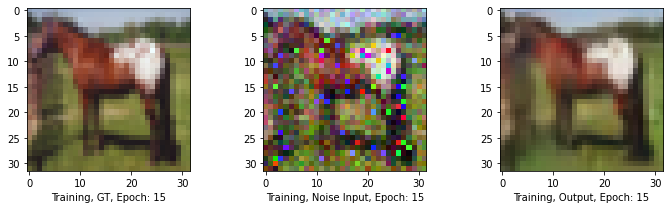

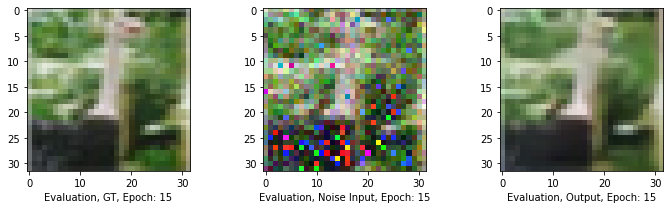

Epoch: 15 => train loss: 0.001483, test loss: 0.001433


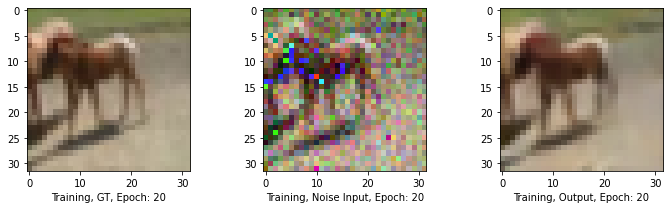

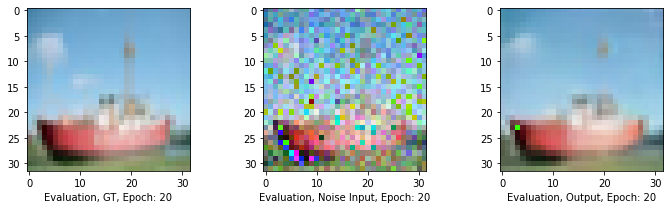

Epoch: 20 => train loss: 0.001465, test loss: 0.001430


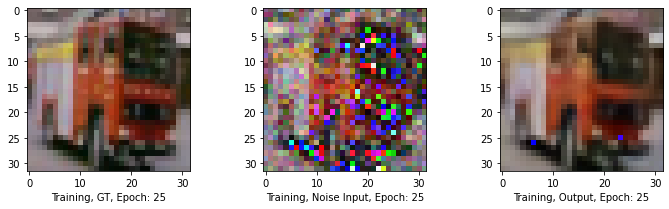

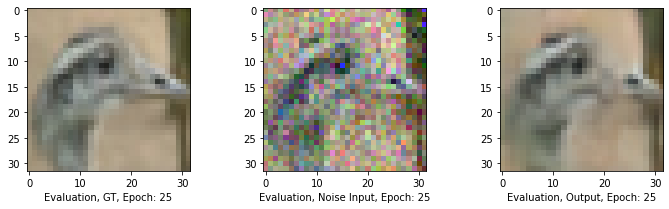

Epoch: 25 => train loss: 0.001453, test loss: 0.001426


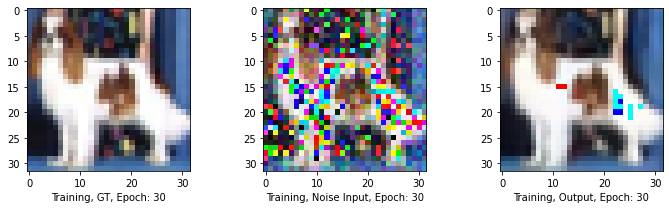

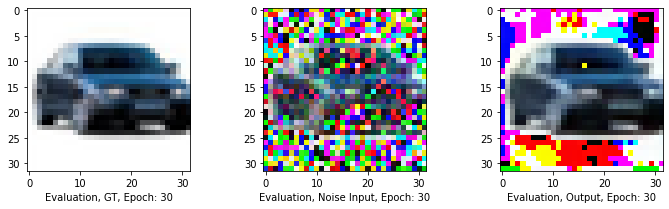

Epoch: 30 => train loss: 0.001445, test loss: 0.001421


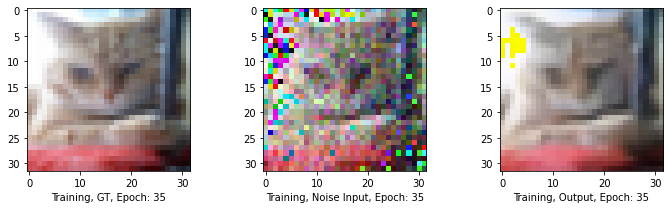

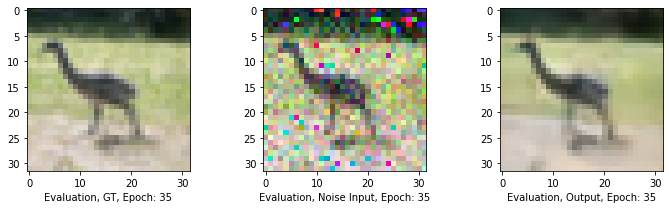

Epoch: 35 => train loss: 0.001438, test loss: 0.001417


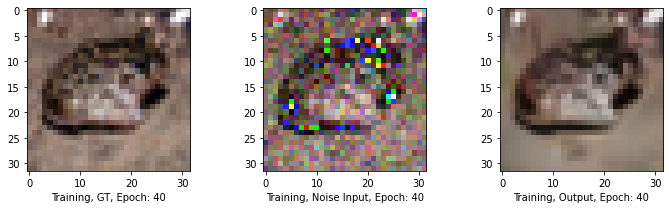

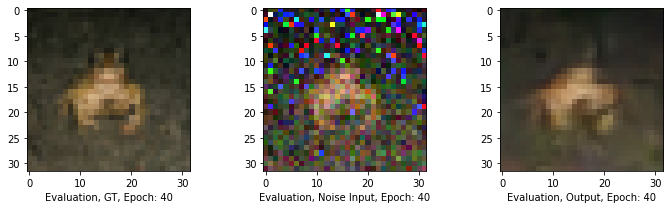

Epoch: 40 => train loss: 0.001432, test loss: 0.001414


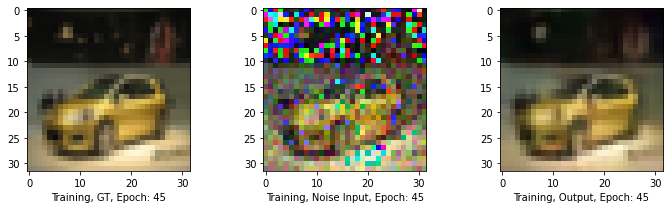

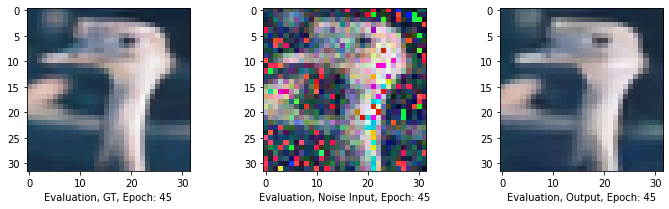

Epoch: 45 => train loss: 0.001427, test loss: 0.001411


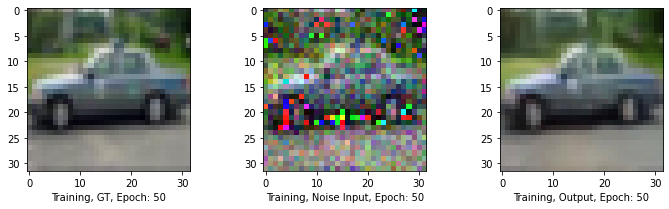

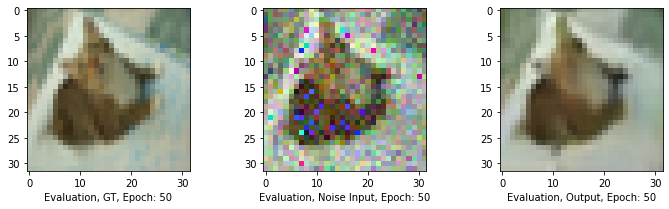

Epoch: 50 => train loss: 0.001423, test loss: 0.001408


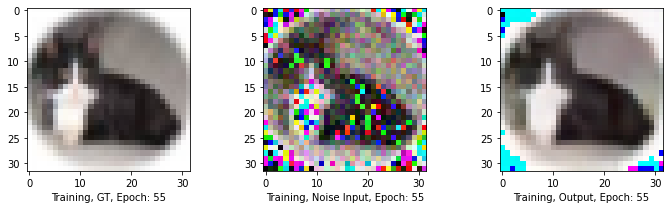

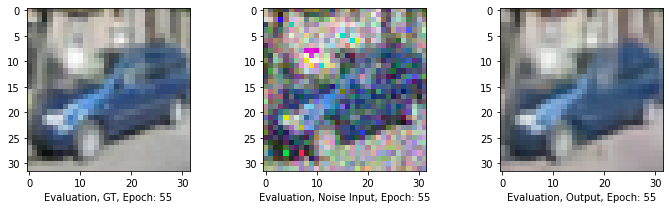

Epoch: 55 => train loss: 0.001420, test loss: 0.001406


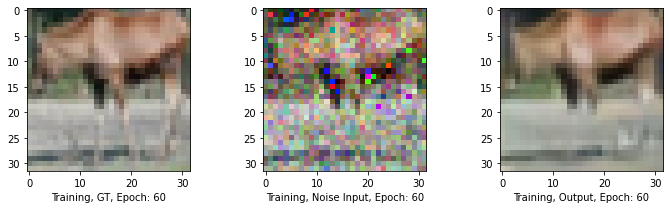

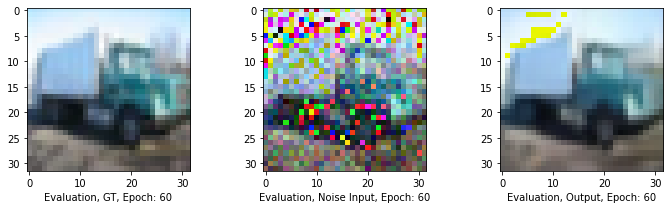

Epoch: 60 => train loss: 0.001417, test loss: 0.001403


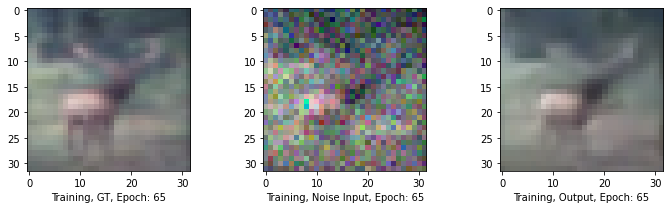

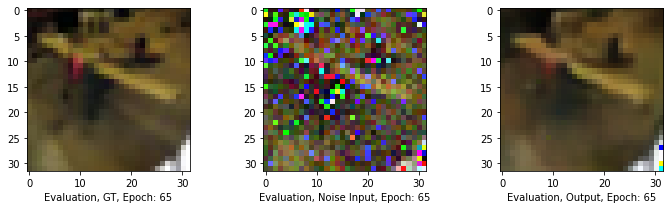

Epoch: 65 => train loss: 0.001414, test loss: 0.001402


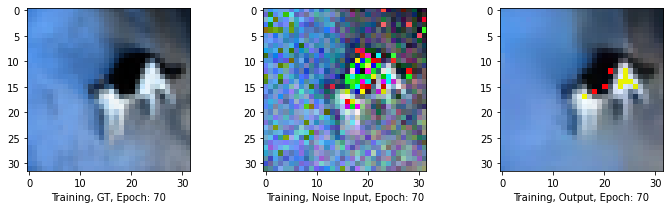

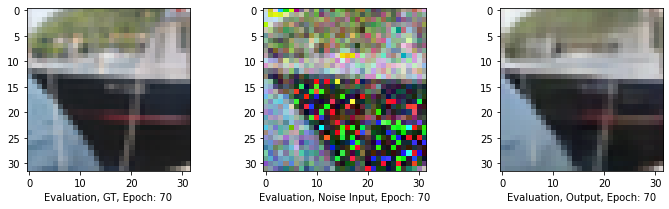

Epoch: 70 => train loss: 0.001411, test loss: 0.001400


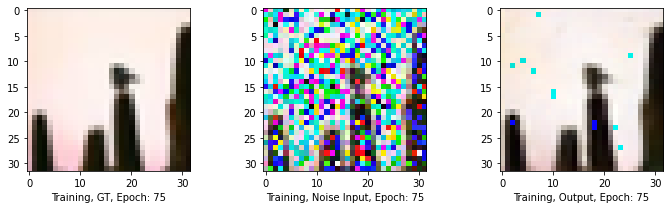

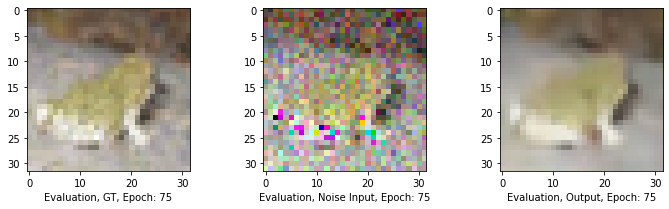

Epoch: 75 => train loss: 0.001409, test loss: 0.001399


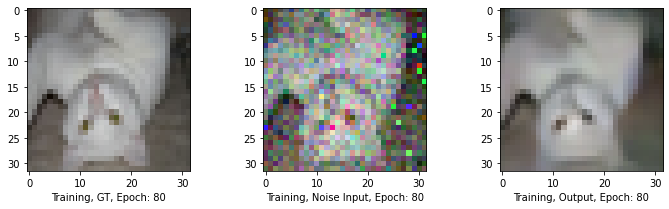

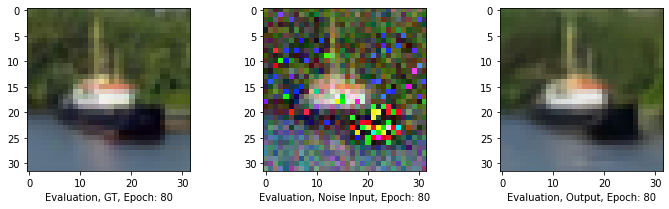

Epoch: 80 => train loss: 0.001407, test loss: 0.001397


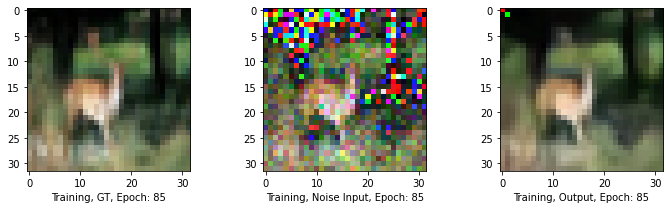

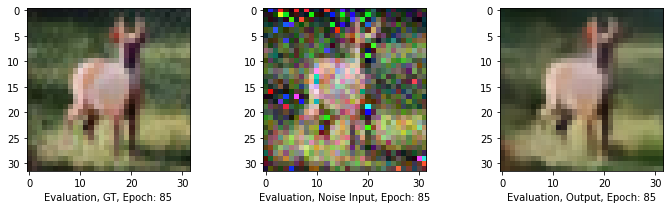

Epoch: 85 => train loss: 0.001405, test loss: 0.001396


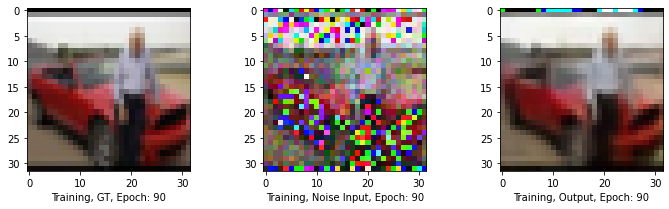

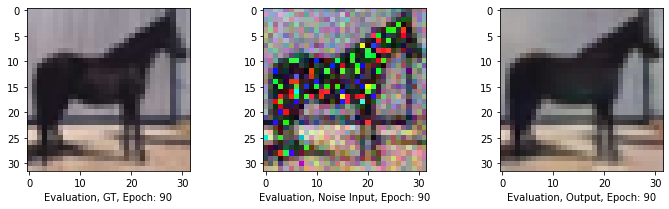

Epoch: 90 => train loss: 0.001403, test loss: 0.001395


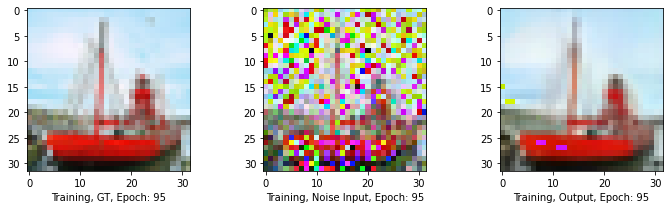

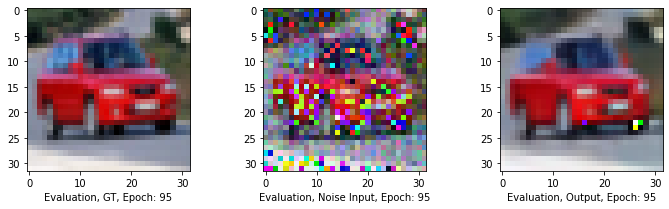

Epoch: 95 => train loss: 0.001401, test loss: 0.001393


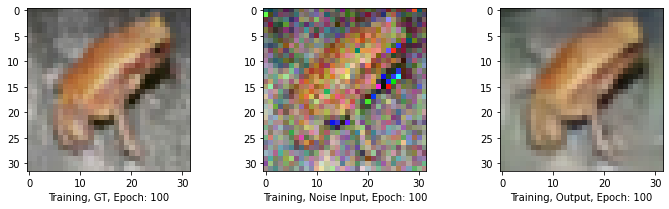

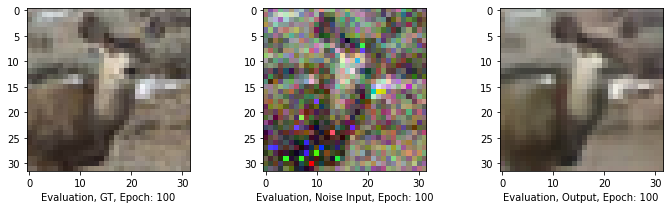

Epoch: 100 => train loss: 0.001400, test loss: 0.001392



In [8]:
	# Train & Evaluate
	tf.keras.backend.set_floatx('float64')
	for epoch in tqdm(range(epochs)):
		# Training
		for idx, (img_input, img_GT) in enumerate(train_dataset):
			with tf.GradientTape() as tape:
				img_output = model_2(img_input, training=True)
				t_loss = loss(img_GT, img_output)
			gradients = tape.gradient(t_loss, model_2.trainable_variables)
			optimizer.apply_gradients(zip(gradients, model_2.trainable_variables))

			train_loss(t_loss)
			if (epoch + 1) % args.log_step == 0 and idx == 0 and args.img_show:
				plot_img(epoch, 'Training', img_output[0], img_GT[0])


		if (epoch + 1) % args.log_step == 0:
			# Evaluation
			for idx, (test_img_input, test_img_GT) in enumerate(test_dataset):
				test_img_output = model_2(test_img_input, training=True)
				t_loss = loss(test_img_GT, test_img_output)

				test_loss(t_loss)
				if (epoch + 1) % args.log_step == 0 and idx == 0 and args.img_show:
					plot_img(epoch, 'Evaluation', test_img_output[0], test_img_GT[0])

			print('Epoch: %d => train loss: %.6f, test loss: %.6f'
					% (epoch+1, train_loss.result(), test_loss.result()))

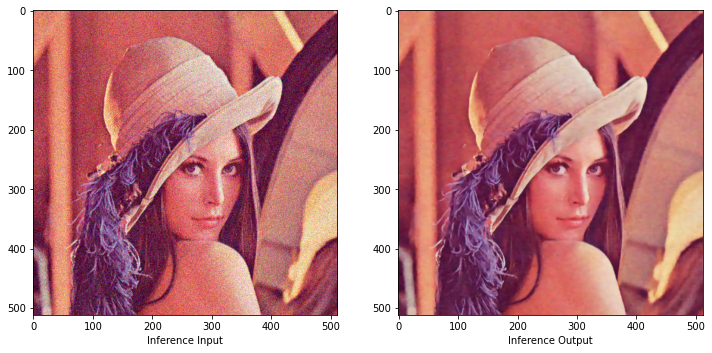

In [9]:
	# Inference
	if args.inference:
		inf_img_input = np.array(Image.open(args.inf_img))
		inf_img_input = np.expand_dims(inf_img_input, 0)
		inf_img_input = inf_img_input / 255.0

		inf_img_output = model_2(inf_img_input)

		if args.img_show:
			plt.figure(figsize=(12,6))
			plt.subplot(1,2,1) 
			plt.imshow((inf_img_input[0]*255).astype(np.uint8))
			plt.xlabel("Inference Input")

			inf_img_output = inf_img_output.numpy()
			plt.subplot(1,2,2)
			plt.imshow((inf_img_output[0]*255).astype(np.uint8))
			plt.xlabel("Inference Output")

		# Save Result
		inf_img_output = (inf_img_output[0]*255).astype(np.uint8)
		Image.fromarray(inf_img_output).save(args.output + 'result2.png')